# Dataset from_tensor_slices 이용하여 입력 파이프라인 구축
+ 본과정에서는 이미지 dataset 구축을 위한 pipeline 구성해 보겠습니다.
+ 이미지 처리하려고 하면 이미지 읽어오기, 이미지 섞기, 배치 사이즈로 나누기등 굉장히 많은 일들이 있습니다.
+ 일일이 이런 일들을 코딩해서 하려고 한다면 굉장히 많은 시간과 노력이 필요할 겁니다.
+ tensorflow의 Dataset 활용해서 DataSet Pipeline(이미지 읽기,섞기,배치등)을 만들어 보겠습니다.
+ 이미 고수준 API 만들어져 있으니 , 우리는 이들을 잘 불러와서 활용할 줄 알면 됩니다.


### 목표 : 이미지 dataSet pipeline 사용해 보기
1. MNIST 데이터를 from_tensor_slices 사용하여 Dataset으로 읽어오기(단, from_tensor_slices는 메모리에 있는 데이터만을 읽어올수 있다.)
2. Dataset에 대해 전처리, 미니배치, 랜덤셔플링등의 데이터 파이프라인을 사용해 전처리 완료된 데이터셋 만들기

### 학습목차
1. Import modules
2. 데이터 불러오기 : Keras Dataset MNIST 활용
3. 이미지 처리 위한 파이프라인 만들기
4. 만든 Dataset에서 샘플 데이터 가져오기
5. DNN 모델 만들고 학습하기

## 1. Import modules

In [ ]:
#import necessary libraries.

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 2. 데이터 불러오기

In [ ]:
# mnist 데이터 메모리로 가져오기

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
print("The shape of train dataset : ", x_train.shape)
print("The shape of test dataset : ", x_test.shape)

The shape of train dataset :  (60000, 28, 28)
The shape of test dataset :  (10000, 28, 28)


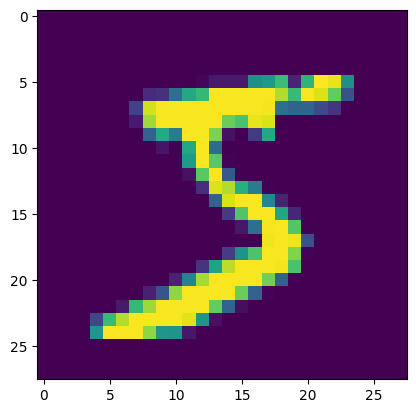

In [ ]:
# x_train 첫번째 이미지 확인하기

plt.imshow(x_train[0])

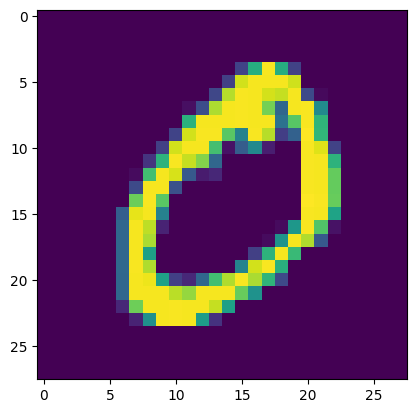

In [ ]:
# x_train 두번째 이미지 확인하기

plt.imshow(x_train[1])

In [ ]:
# Add a channels dimension . 이미지 사이즈로 만들어 줌. 원래 이미지는 Hight X Width X Channel 3차원으로 구성됨
# x_train.reshape(-1, 28, 28 ,1) 사용해도 된다.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [ ]:
print("The shape of train dataset : ", x_train.shape)
print("The shape of test dataset : ", x_test.shape)

The shape of train dataset :  (60000, 28, 28, 1)
The shape of test dataset :  (10000, 28, 28, 1)


## 3. 이미지 처리 위한 파이프라인 만들기
+ from_tensor_slices : 입력 받기
+ shuffle
+ batch
+ cache(데이터 일부를 캐시메모리에 저장할 수 있도록 함),
+ prefetch(모델이 s번째 데이터를 읽는 동안, s+1번째 데이터를 준비)

In [ ]:
# 파이프라인 구성

AUTOTUNE = tf.data.experimental.AUTOTUNE

# train dataset
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))  # 여러개 입력시 튜플 입력
train_ds = train_ds.shuffle(10000)
train_ds = train_ds.batch(32)
train_ds = train_ds.prefetch(AUTOTUNE)

# test dataset : shuffle 하지 않음
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(32)
test_ds = test_ds.prefetch(AUTOTUNE)

## 4. 만든 Dataset에서 샘플 데이터 가져오기

In [ ]:
# Train 데이터셋 확인
# (None, 28, 28, 1), (None,) 2개의 값으로 구성

train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

In [ ]:
# iter , next 통해서 1개의 샘플 데이터 가져오기
x_train_sample, y_train_sample = next(iter(train_ds))

In [ ]:
# 가져온 1개 샘플 데이터에 대한 shape 확인
# 첫번째 샘플은 1개의 batch로 32개 이미지 구성
# 두번째 샘플은 32개의 label 구성

print(x_train_sample.shape, y_train_sample.shape)

(32, 28, 28, 1) (32,)


In [ ]:
# 가져온 샘플 타입 확인
print(type(x_train_sample), type(y_train_sample))

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


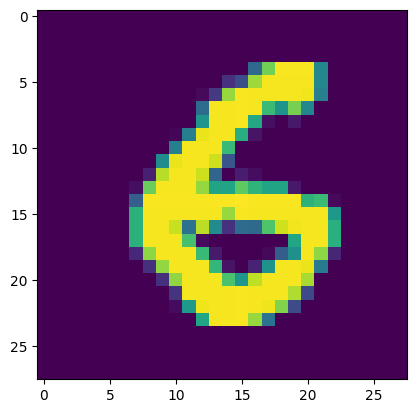

In [ ]:
# 가져온 첫번째 샘플 이미지 확인
plt.imshow(x_train_sample[0])

## 5. DNN 모델 만들고 학습하기

In [ ]:
# 모델 정의

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
# 모델 compile 및 학습.

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

history = model.fit(train_ds, epochs=5, batch_size=32, validation_data=(test_ds))

Epoch 1/5
1875/1875 [==============================] - 13s 4ms/step - loss: 0.2810 - sparse_categorical_accuracy: 0.9204 - val_loss: 0.1447 - val_sparse_categorical_accuracy: 0.9557
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1307 - sparse_categorical_accuracy: 0.9614 - val_loss: 0.1170 - val_sparse_categorical_accuracy: 0.9635
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0950 - sparse_categorical_accuracy: 0.9713 - val_loss: 0.0998 - val_sparse_categorical_accuracy: 0.9690
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0745 - sparse_categorical_accuracy: 0.9771 - val_loss: 0.0972 - val_sparse_categorical_accuracy: 0.9706
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0594 - sparse_categorical_accuracy: 0.9805 - val_loss: 0.0927 - val_sparse_categorical_accuracy: 0.9734


In [ ]:
# 모델 평가
# 모델 평가시 보평 입력 데이터를 X_test, y_test 이런식으로 들어가는데, 우리는 데이터셋을 만들어서 그냥 데이터셋을 넣어 주면 됨

model.evaluate(test_ds)

313/313 [==============================] - 1s 3ms/step - loss: 0.0927 - sparse_categorical_accuracy: 0.9734


[0.09268274903297424, 0.9733999967575073]

## 배운 내용 정리
1. 이미지 dataset pipeline 만들어 보았습니다.
2. from_tensor_slices 함수를 이용하여 필요한 데이터를 Dataset으로 읽어와
3. 읽어온 데이터를 파이프라인을 통하여 shuffle, batch, cache, prefetch된 Dataset을 만들수 있다.
4. 외우지 못해도 이런식으로 사용할수 있다는것을 알고 필요할때 사용해도 됩니다.